In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install pyspark
!pip install dask[dataframe]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.6 MB/s eta 0:00:0000:0100:03
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840626 sha256=605babf82004ed1ef6251972603515dcbdc2ca63015330178808ddcfce104062
  Stored in directory: /Users/nushrat/Library/Caches/pip/wheels/07/a0/a3/d24c94bf043ab5c7e38c30491199a2a11fef8d2584e6df7fb7
Successfully built pyspark
zsh:1: no matches found: dask[dataframe]


In [ ]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Yelp Data Merge") \
    .getOrCreate()

In [ ]:



business_csv = '/content/drive/MyDrive/yelp_dataset_csv/yelp_academic_dataset_business.csv'
#review_csv = '/content/drive/MyDrive/yelp_dataset_csv/yelp_academic_dataset_review.csv'


business_df = spark.read.csv(business_csv, header=True, inferSchema=True)


business_df = business_df.withColumnRenamed("stars", "overall_star")

#review_df = review_df.withColumnRenamed("stars", "personal_star")

#merged_df = business_df.join(review_df, on='business_id', how='inner')

In [ ]:
business_df.show(5)

+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+------------+------------+-------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|         city|state|postal_code|  latitude|   longitude|overall_star|review_count|is_open|          attributes|          categories|               hours|
+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+------------+------------+-------+--------------------+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|1616 Chapala St, ...|Santa Barbara|   CA|      93101|34.4266787|-119.7111968|         5.0|         7.0|      0|{'ByAppointmentOn...|Doctors, Traditio...|                NULL|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|87 Grasso Plaza S...|       Affton|   MO|      63123| 38.551126|  -90.335695|        

In [ ]:
#merged_df.write.csv('/content/drive/MyDrive/yelp_dataset_csv/merged_yelp_data.csv', header=True)

In [ ]:
# Show basic statistics
business_df.describe().show()

+-------+--------------------+--------------------+------------------+--------------------+------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+
|summary|         business_id|                name|           address|                city| state|      postal_code|          latitude|         longitude|      overall_star|      review_count|           is_open|          attributes|          categories|               hours|
+-------+--------------------+--------------------+------------------+--------------------+------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+
|  count|              150346|              150346|            145219|              150346|150346|           150273|            150346|            150346|            150346|  

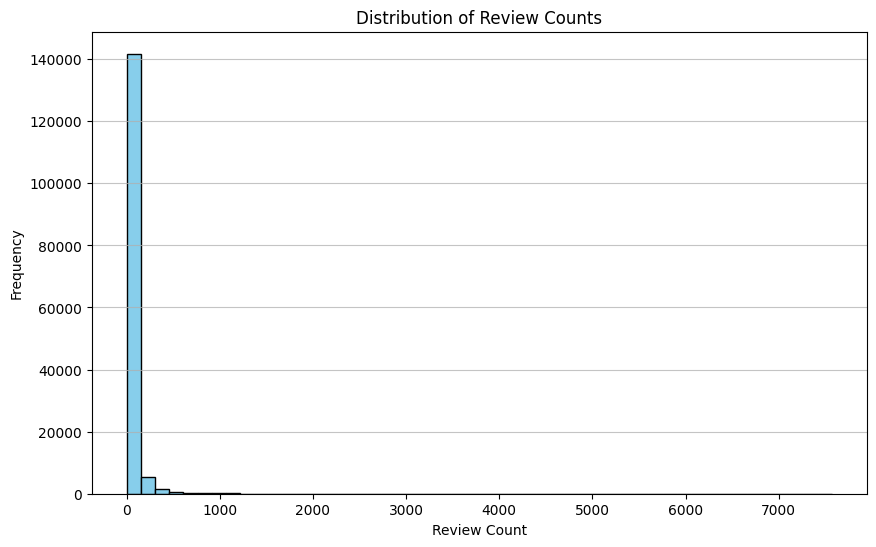

In [ ]:
import matplotlib.pyplot as plt

review_counts = business_df.select("review_count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.hist(review_counts, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.title('Distribution of Review Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

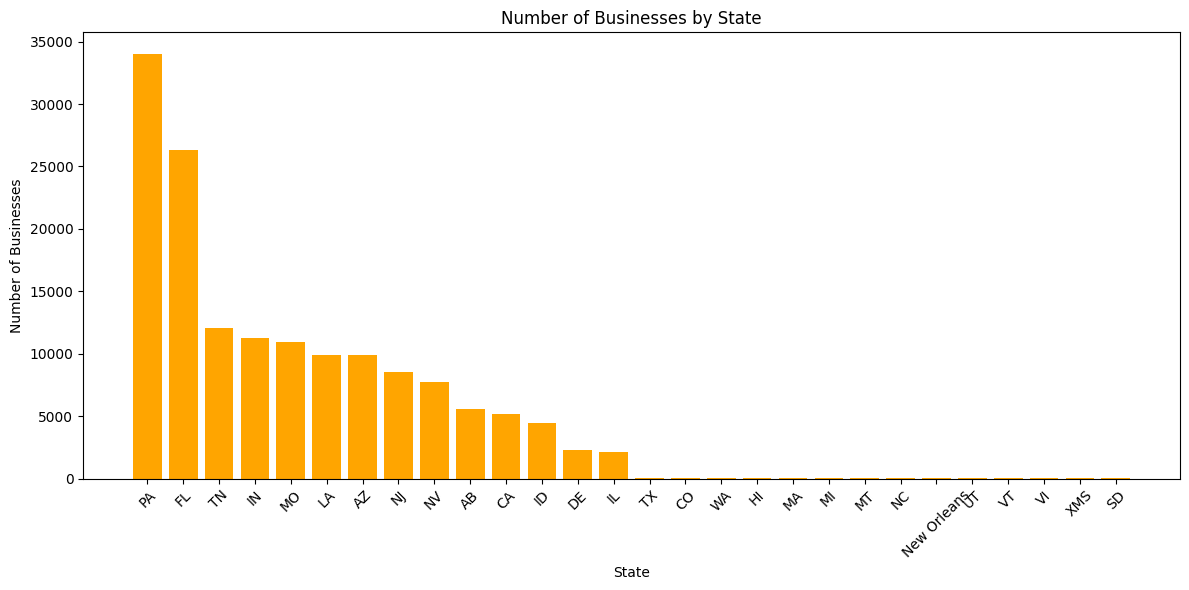

In [ ]:

business_count_by_state = business_df.groupBy("state").count().orderBy("count", ascending=False)


state_counts = business_count_by_state.toPandas()


plt.figure(figsize=(12, 6))
plt.bar(state_counts['state'], state_counts['count'], color='orange')
plt.xlabel('State')
plt.ylabel('Number of Businesses')
plt.title('Number of Businesses by State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

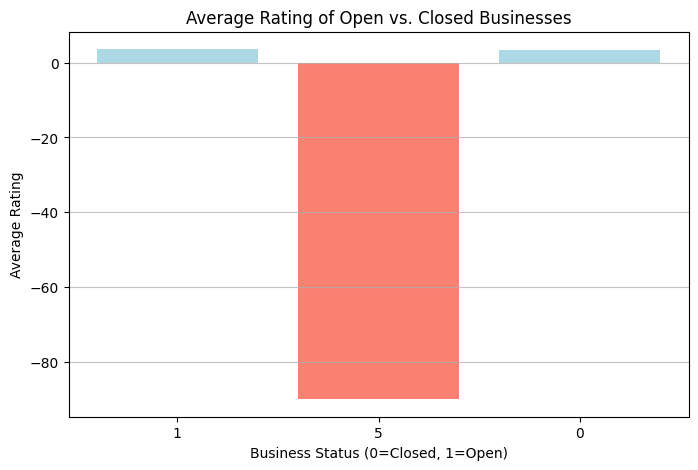

In [ ]:

open_closed_rating = business_df.groupBy("is_open").agg({"overall_star": "avg", "business_id": "count"}).withColumnRenamed("count(business_id)", "business_count").toPandas()


plt.figure(figsize=(8, 5))
plt.bar(open_closed_rating['is_open'].astype(str), open_closed_rating['avg(overall_star)'], color=['lightblue', 'salmon'])
plt.xlabel('Business Status (0=Closed, 1=Open)')
plt.ylabel('Average Rating')
plt.title('Average Rating of Open vs. Closed Businesses')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:

average_rating_by_state =business_df.groupBy("state").agg({"overall_star": "avg"}).withColumnRenamed("avg(overall_star)", "average_rating").orderBy("average_rating", ascending=False)


top_states = average_rating_by_state.limit(5)
top_states_pd = top_states.toPandas()
top_states_list = top_states_pd['state'].tolist()


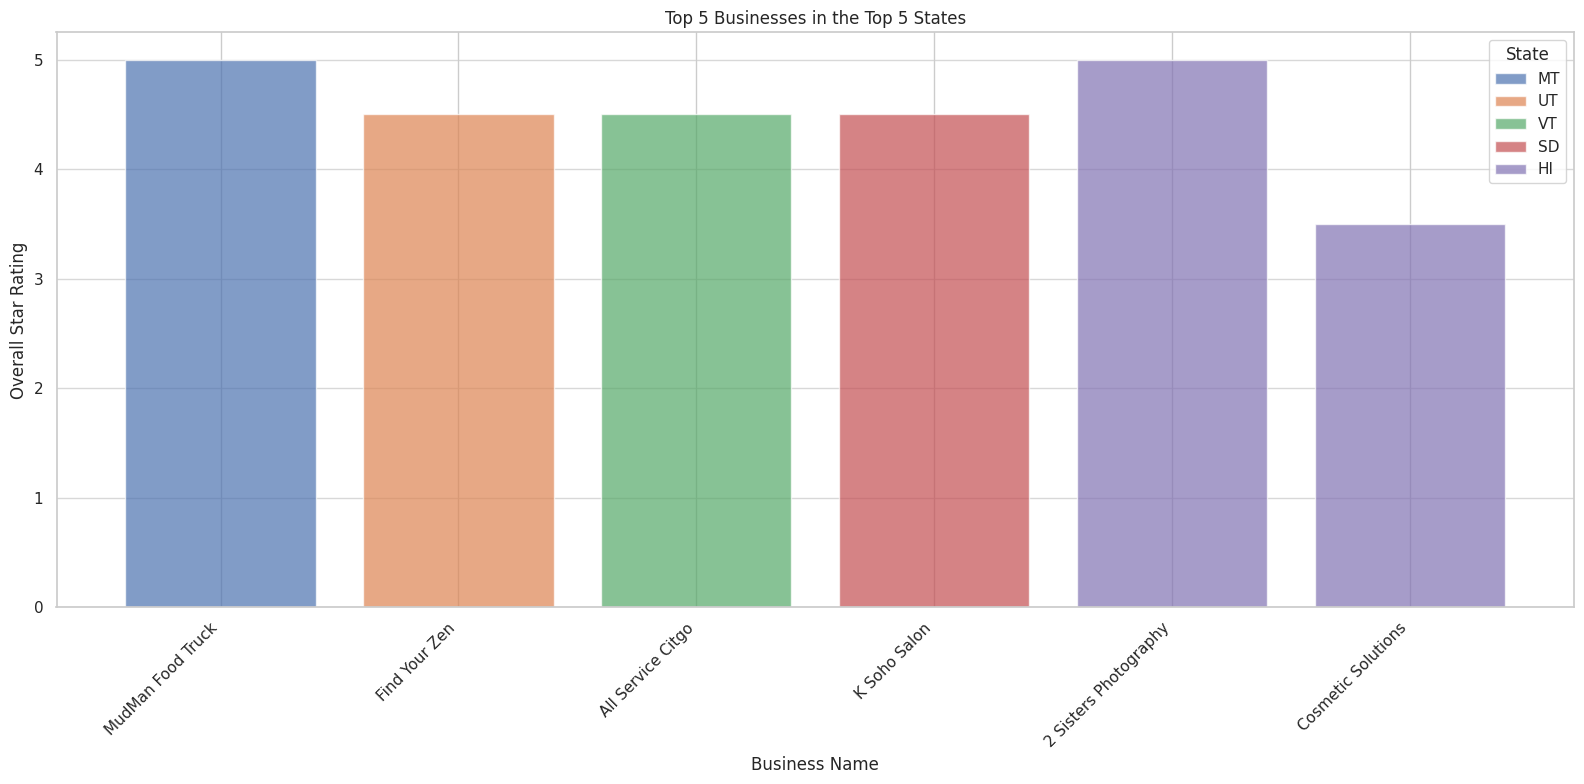

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
import matplotlib.pyplot as plt
import seaborn as sns

window_spec = Window.partitionBy("state").orderBy(business_df.overall_star.desc())


top_businesses_final = ranked_businesses_top_states.filter(ranked_businesses_top_states.rank <= 5).select("state", "name", "overall_star")
top_businesses_final_pd = top_businesses_final.toPandas()


sns.set(style="whitegrid")

palette = sns.color_palette("husl", len(top_states_list))

plt.figure(figsize=(16, 8))

for state in top_states_list:
    state_data = top_businesses_final_pd[top_businesses_final_pd['state'] == state]
    plt.bar(state_data['name'], state_data['overall_star'], label=state, alpha=0.7)

plt.xlabel('Business Name')
plt.ylabel('Overall Star Rating')
plt.title('Top 5 Businesses in the Top 5 States')
plt.xticks(rotation=45, ha='right')
plt.legend(title='State')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


In [ ]:
import dask.dataframe as dd

df = business_df.toPandas()

df_dask = dd.from_pandas(df, npartitions=4)

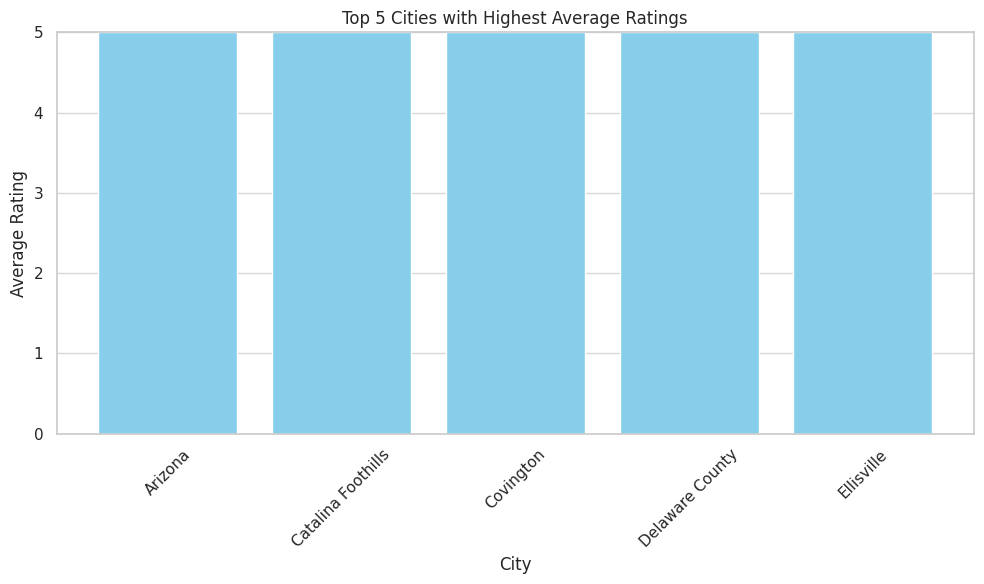

In [ ]:

average_rating_by_city = df_dask.groupby('city')['overall_star'].mean().nlargest(5).compute()
average_rating_by_city_pd = average_rating_by_city.reset_index()
average_rating_by_city_pd.columns = ['city', 'average_rating']


import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.bar(average_rating_by_city_pd['city'], average_rating_by_city_pd['average_rating'], color='skyblue')
plt.xlabel('City')
plt.ylabel('Average Rating')
plt.title('Top 5 Cities with Highest Average Ratings')
plt.xticks(rotation=45)
plt.ylim(0, 5)  
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00


In [ ]:
import dask.dataframe as dd
import csv

dask_df = dd.read_csv('/content/drive/MyDrive/yelp_dataset_csv/yelp_academic_dataset_review.csv', on_bad_lines='skip', lineterminator='\n', quoting=csv.QUOTE_NONE, low_memory=False)  # Adjust the path as needed

In [ ]:
cleaned_df = dask_df.compute()

In [5]:
import dask.dataframe as dd
import re
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments